In [1]:
import math

## Setup

In [2]:
# ((0.046 - 0.0042) / 7080000) * 1000000

In [3]:
# # 3rm
# model_size = 11544930 * 4 * 8
# param_size = round(model_size / 32)
# add_p = 0.0023
# mul_time_per_million = 0

# nr_layer = 5
# nr_worker = 3
# recv_ratio = 98.35 / 100

# bandwidth_dict = {}
# bandwidth_dict["s2c"] = 60.42 * 1000 * 1000
# bandwidth_dict["c2c"] = 60.42 * 1000 * 1000
# bandwidth_dict["c2w"] = 851.1 * 1000 * 1000

# time_cmd = 0.0014

# gis_real_value = 6
# emp_real_value = 52.5
# agg_real_value = 0.28
# dec_real_value = 2.83

In [4]:
# # 6rm
# model_size = 11544930 * 4 * 8
# param_size = round(model_size / 32)
# add_time_per_million = 0.0195
# add_p = 0.0023
# mul_time_per_million = 0

# nr_layer = 5
# nr_worker = 6
# recv_ratio = 98.35 / 100

# bandwidth_dict = {}
# bandwidth_dict["s2c"] = 60.42 * 1000 * 1000
# bandwidth_dict["c2c"] = 60.42 * 1000 * 1000
# bandwidth_dict["c2w"] = 851.1 * 1000 * 1000

# time_cmd = 0.0014

# gis_real_value = 6.5
# emp_real_value = 140.7
# agg_real_value = 1.185
# dec_real_value = 5.4

In [5]:
# 12rm
model_size = 11544930 * 4 * 8
param_size = round(model_size / 32)
add_time_per_million = 0.0195
add_p = 0.0023
mul_time_per_million = 0

nr_layer = 5
nr_worker = 12
recv_ratio = 98.35 / 100

bandwidth_dict = {}
bandwidth_dict["s2c"] = 60.42 * 1000 * 1000
bandwidth_dict["c2c"] = 60.42 * 1000 * 1000
bandwidth_dict["c2w"] = 851.1 * 1000 * 1000

time_cmd = 0.0016

gis_real_value = 7.6
emp_real_value = 311.8
agg_real_value = 5.62
dec_real_value = 10.2

In [6]:
def ratio(pred_value, real_value):
    return pred_value / real_value

## GIS Prediction

In [7]:
def gis_prediction():
    return model_size / bandwidth_dict["s2c"] + model_size / bandwidth_dict["s2c"] * (1-recv_ratio) * (nr_worker-1)

In [8]:
gis_prediction()

7.224275296921554

In [9]:
gis_real_value

7.6

In [10]:
ratio(gis_prediction(), gis_real_value)

0.9505625390686255

## Local Training Prediction

In [11]:
"""
data_kargs:
    * data.shape: List
    * nr_bits for the type of data: int
    * label.shape: List
    * nr_bits for the type of label: int
fb_kargs:
    * bandwidth (Mbps): float
    * constant: float
cmp_kargs:
    * gflops: float
    * constant: float
"""
def local_training_predictor(model_flops, data_kargs, fb_kargs, cmp_kargs):
    nr_data_element = 1
    for nr in data_kargs["data"]["shape"]:
        nr_data_element = nr * nr_data_element
        
    nr_data_bits = nr_data_element * data_kargs["data"]["type_bits"]
    
    nr_label_element = 1
    for nr in data_kargs["label"]["shape"]:
        nr_label_element = nr * nr_label_element
        
    nr_label_bits = nr_label_element * data_kargs["label"]["type_bits"]
    
    nr_batch_bits = data_kargs["batch_size"] * (nr_label_bits + nr_data_bits)
    nr_batch = math.ceil(data_kargs["data_size"] / data_kargs["batch_size"])
    fetch_batch_time = nr_batch_bits / (fb_kargs["mbps"] * 1024 * 1024) + fb_kargs["constant"]
    comp_batch_time = (data_kargs["batch_size"] * model_flops) / (cmp_kargs["gflops"] * 1024 * 1024 * 1024) + cmp_kargs["constant"]
    
    predict_value = nr_batch * (fetch_batch_time + comp_batch_time)
    
    return fetch_batch_time, comp_batch_time, predict_value

In [12]:
label_name = "resnet_18"

model_flops_dict = {
    "original": 2307720 * 2 * 3,
    "resnet_18": 13412720 * 2 * 3,
    "resnet_34": 23747720 * 2 * 3,
    "resnet_50": 25437720 * 2 * 3
}

lt_real_value_dict = {
    "original": 13.57,
    "resnet_18": 26.76,
    "resnet_34": 42.67,
    "resnet_50": 45.167
}

model_flops = model_flops_dict[label_name]

data_kargs = {}
data_kargs["data"] = {}
data_kargs["label"] = {}
data_kargs["data_size"] = 24754
data_kargs["batch_size"] = 64
data_kargs["data"]["shape"] = [28, 28]
data_kargs["data"]["type_bits"] = 32
data_kargs["label"]["shape"] = [1]
data_kargs["label"]["type_bits"] = 64

fb_kargs = {}
fb_kargs["mbps"] = 180.93
fb_kargs["constant"] = 0.0082

cmp_kargs = {}
cmp_kargs["gflops"] = 92
cmp_kargs["constant"] = 0.00623

lt_real_value = lt_real_value_dict[label_name]

In [13]:
model_flops

80476320

In [14]:
_, _, pred_time = local_training_predictor(model_flops, data_kargs, fb_kargs, cmp_kargs)

In [15]:
pred_time

29.045716157068497

In [16]:
lt_real_value

26.76

In [17]:
pred_time / 20.61

1.4093020939868266

## EMP

In [18]:
def emp_prediction():
    time_fixed_model = (2 * model_size) / bandwidth_dict["c2c"]
    return (nr_worker - 1) * (1 + recv_ratio) * time_fixed_model + mul_time_per_million * (param_size/1000000)

In [19]:
emp_prediction()

266.818198164846

In [20]:
emp_real_value

311.8

In [21]:
ratio(emp_prediction(), emp_real_value)

0.8557350807082938

## Aggregation prediction

In [22]:
nr_layer

5

In [23]:
add_p

0.0023

In [24]:
# p_list = [500, 20, 25000, 50, 7080000, 8850, 4425000, 500, 5000, 10]
# agg_time = 0
# for p in p_list:
#     single_add_time = add_p * (p / 1000000) + time_cmd * nr_worker
#     layer_time = single_add_time * (nr_worker-1)
#     print(single_add_time, layer_time)
#     agg_time += layer_time

In [25]:
def agg_prediction():
    return 2 * nr_layer * ((nr_worker - 1) * (nr_worker * time_cmd)) + (nr_worker - 1) * nr_worker *  (param_size/1000000) * add_p

In [26]:
# def agg_prediction():
#     return 2 * nr_layer * ((nr_worker - 1) * (nr_worker * time_cmd)) + (nr_worker - 1) *  (param_size/1000000) * add_p

In [27]:
agg_prediction()

5.617040748000001

In [28]:
agg_real_value

5.62

In [29]:
ratio(agg_prediction(), agg_real_value)

0.9994734427046265

## Decryption prediction

In [30]:
def dec_prediction():
    return nr_worker * (model_size * 2 / bandwidth_dict["c2w"])

In [31]:
dec_prediction()

10.417702079661614

In [32]:
dec_real_value

10.2

In [33]:
ratio(dec_prediction(), dec_real_value)

1.0213433411432955

/home/posheng/miniconda3/envs/syft-0.2.5/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


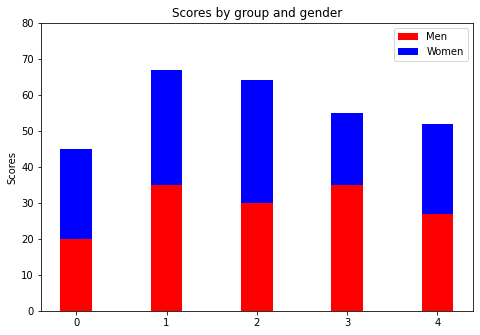

In [60]:
import numpy as np
import matplotlib.pyplot as plt
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Men', 'Women'])
plt.show()

### Model Size

/home/posheng/miniconda3/envs/syft-0.2.5/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


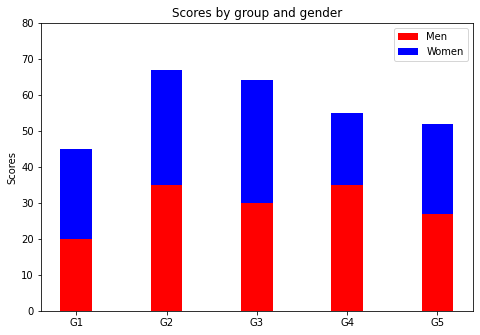

In [73]:
import numpy as np
import matplotlib.pyplot as plt
N = 5
gis = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, menMeans, width, color='r')
ax.bar(ind, womenMeans, width,bottom=menMeans, color='b')
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
# ax.set_xticks(('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_xticklabels(["G0", 'G1', 'G2', 'G3', 'G4', 'G5']) 
ax.set_yticks(np.arange(0, 81, 10))
ax.legend(labels=['Men', 'Women'])
plt.show()